### Overview
This Jupyter notebook can be used to retrieve the pitch data from [pybaseball](https://github.com/jldbc/pybaseball), export it as a csv, and also how to import the csv for future use.

Assumptions:
- Treating complete games as the pitcher getting pulled in the 9th has a negligible effect. Technically, the 3 games are "censored data," but it's a drop in the bucket of data and the pitchers have high pitch counts at the end of their CGs and likely wouldn't have been pitching much longer had the games continued.
- An old Leverage Index table from the mid 00's is a satisfactory substitute for the '25 Leverage Index table. It'd take much more data wrangling to build up this season's table, and it's much easier to scrape the values from Tom Tango's site.
- The cumulative Leverage Index is multiplicatively related to the survival outcome. Necessary to use the Cox PH model, reasonable since the CLI is a measure of how many stressful situation the pitcher has been in and is associated with performance.

#### Retrieveing the data

In [1]:
# Import necessary libraries
import pybaseball as pyb
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bs4 import BeautifulSoup
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.util import Surv
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder


import requests

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Importing the data
Only run these once you've either ran the above cells, or if you've downloaded and unzipped the file from [our GitHub](https://github.com/Erdos-Projects/fall-2025-sports-analytics)

In [112]:
# df = pyb.statcast(start_dt='2025-09-01', end_dt='2025-09-30')[::-1]
df = pd.read_csv('all_september_2025_pitches.csv') [::-1] # reverse to get the order correct

In [113]:
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
3921,FF,2025-09-01,98.6,-2.10,5.34,"Dollander, Chase",671218,801403,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,2,Called Strike,R,R,R,COL,SF,S,<NA>,NaN,0,0,2025,-0.90,0.67,0.17,2.73,<NA>,<NA>,<NA>,0,1,Top,NaN,NaN,<NA>,<NA>,<NA>,<NA>,8.224720,-143.683098,-3.325257,-14.109707,24.014700,-22.277456,3.06,1.43,<NA>,NaN,<NA>,99.3,2572,6.0,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.53,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,1,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,230,0.000,-0.039,NaN,NaN,NaN,0.039,NaN,0,0,0.500,0.500,23,25,24,26,1,0,5,1,7,1,1.62,0.90,0.90,21.8,NaN,NaN,NaN,NaN,NaN
3823,SI,2025-09-01,96.9,-2.11,5.30,"Dollander, Chase",671218,801403,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,"Heliot Ramos grounds out, shortstop Ezequiel T...",R,R,R,COL,SF,X,6,ground_ball,0,1,2025,-1.34,0.32,-0.37,3.03,<NA>,<NA>,<NA>,0,1,Top,109.76,157.26,<NA>,<NA>,<NA>,<NA>,7.659224,-140.999181,-1.294907,-19.565270,29.315769,-27.846546,3.13,1.47,4,68.5,-38,96.5,2424,5.9,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.62,0.08,0.076,0.0,1,0,0,2,1,2,Sinker,0,0,0,0,0,0,0,0,Standard,Standard,236,0.022,-0.220,75.8,6.4,0.08,0.220,88.0,0,0,0.500,0.500,23,25,24,26,1,0,5,1,7,1,2.09,1.34,1.34,20.2,2.725533,4.178553,22.526160,32.109508,23.069677
3677,FF,2025-09-01,98.9,-1.97,5.39,"Dollander, Chase",646240,801403,NaN,ball,<NA>,<NA>,<NA>,<NA>,12,Ball,R,L,R,COL,SF,B,<NA>,NaN,0,0,2025,-1.13,1.16,0.93,4.20,<NA>,<NA>,<NA>,1,1,Top,NaN,NaN,<NA>,<NA>,<NA>,<NA>,10.440505,-143.651725,-0.525088,-17.971889,32.344342,-16.204343,3.57,1.72,<NA>,NaN,<NA>,98.2,2443,5.9,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.56,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,2,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Infield shade,Standard,233,0.000,0.039,NaN,NaN,NaN,-0.039,NaN,0,0,0.522,0.478,23,28,24,29,1,0,5,1,7,1,1.18,1.13,-1.13,20.3,NaN,NaN,NaN,NaN,NaN
3553,FF,2025-09-01,99.5,-2.20,5.32,"Dollander, Chase",646240,801403,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,1,Called Strike,R,L,R,COL,SF,S,<NA>,NaN,1,0,2025,-0.98,0.97,-0.42,3.20,<NA>,<NA>,<NA>,1,1,Top,NaN,NaN,<NA>,<NA>,<NA>,<NA>,7.084344,-144.795188,-2.702035,-15.346089,32.174972,-18.028990,3.45,1.57,<NA>,NaN,<NA>,98.8,2385,5.8,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.69,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,2,2,4-Seam Fastball,0,0,0,0,0,0,0,0,Infield shade,Standard,233,0.000,-0.049,NaN,NaN,NaN,0.049,NaN,0,0,0.522,0.478,23,28,24,29,1,0,5,1,7,

In [6]:
first_pitch_per_pitcher = df.groupby(['game_pk', 'pitcher']).head(1)

# Step 2: Starters are those whose first pitch came in inning 1 (top or bottom)
# Warning, this line really takes anyone whose first pitch was in 1st inning and calls them a starter
# So if a starter has a meltdown and a reliever comes in in the 1st, this is still labeling the reliever a starter
starters = first_pitch_per_pitcher[first_pitch_per_pitcher['inning'] == 1]

# Step 3: Create starter ID pairs (game_pk, pitcher)
starter_ids = starters[['game_pk', 'pitcher']].drop_duplicates()

# Step 4: Label each row in the full DataFrame as 'starter' or 'reliever'
df = df.copy()  # avoid SettingWithCopyWarning

is_starter = pd.MultiIndex.from_frame(df[['game_pk','pitcher']]).isin(
    pd.MultiIndex.from_frame(starter_ids)
)
df['role'] = np.where(is_starter, 'starter', 'reliever')


In [7]:
dfs = df[df['role'] == 'starter'].copy()

In [8]:
dfs['base_state'] = (
    dfs['on_1b'].notna().astype(int).astype(str) +
    dfs['on_2b'].notna().astype(int).astype(str) +
    dfs['on_3b'].notna().astype(int).astype(str)
)

In [9]:
dfs['pitch_count'] = dfs.groupby(['game_pk', 'pitcher']).cumcount() + 1

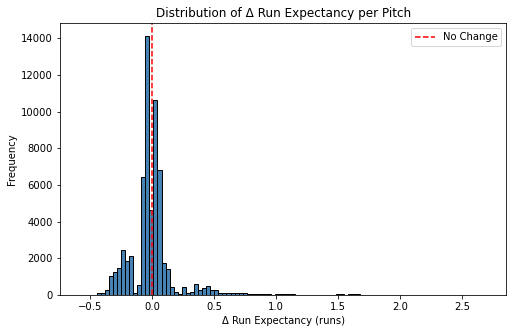

In [10]:
plt.figure(figsize=(8,5))
plt.hist(dfs['delta_run_exp'], bins=100, color='steelblue', edgecolor='k')
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.title('Distribution of Δ Run Expectancy per Pitch')
plt.xlabel('Δ Run Expectancy (runs)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
# Create a boolean column: True if this is the last pitch by pitcher in game
dfs['last_pitch_of_game'] = dfs.groupby(['game_pk', 'pitcher'])['pitch_count'].transform('idxmax') == dfs.index

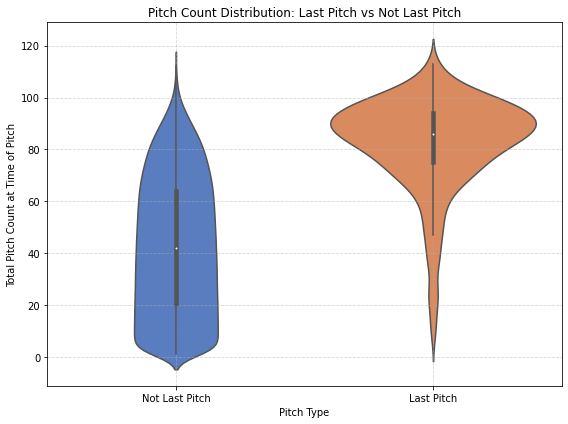

In [12]:
# Optional: Make labels more readable
dfs['is_last_pitch'] = dfs['last_pitch_of_game'].map({True: 'Last Pitch', False: 'Not Last Pitch'})

# Create violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=dfs, x='is_last_pitch', y='pitch_count', inner='box', palette='muted')

# Customize plot
plt.title('Pitch Count Distribution: Last Pitch vs Not Last Pitch')
plt.xlabel('Pitch Type')
plt.ylabel('Total Pitch Count at Time of Pitch')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [13]:
dfs[dfs['last_pitch_of_game']][['game_date','player_name','pitch_count']]

,game_date,player_name,pitch_count
109820,2025-09-01,"Dollander, Chase",84
109776,2025-09-01,"Teng, Kai-Wei",85
109504,2025-09-01,"Cease, Dylan",91
109490,2025-09-01,"Bradish, Kyle",84
109165,2025-09-01,"Nelson, Ryne",97
109147,2025-09-01,"Corbin, Patrick",92
108847,2025-09-01,"Morales, Luis",91
108830,2025-09-01,"Gray, Sonny",82
108673,2025-09-01,"Bachar, Lake",39
108597,2025-09-01,"Alvarez, Andrew",81


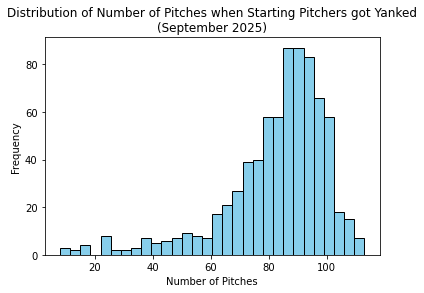

In [116]:
# import matplotlib.pyplot as plt
# import numpy as np

# Generate random data for the histogram
data = dfs[dfs['last_pitch_of_game']][['pitch_count', 'pitcher']]
# Plotting a basic histogram
plt.hist(data['pitch_count'], bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Number of Pitches')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Pitches when Starting Pitchers got Yanked\n(September 2025)')

# Display the plot
plt.show()

In [123]:
data.describe().apply(lambda x: round(x, 2))

,pitch_count,pitcher
count,754.00,754.00
mean,82.35,654849.10
std,18.06,63642.51
min,8.00,434378.00
25%,75.00,622503.00
50%,86.00,669194.00
75%,94.00,683004.00
max,113.00,815083.00


In [16]:
sum(data['pitch_count'] >= 100)

81

In [17]:
len(data)

754

According to [this](https://www.espn.com/mlb/history/leaders/_/type/0/breakdown/season/year/2025/sort/completeGames) source, there were 29 complete games in the regular season this year. Those appearances would be considered 'censored'. Since it's such a small fraction of the total games, and since pitchers who pitched a complete game have thrown a lot of pitches and are likely close to when they'd be pulled, we'll ignore the fact that they're censored and assume that the extra length they'd go is negligible. [This](https://www.mlb.com/stories/mlb-complete-games-thrown-2025) reel shows that there were only 3 CGs in September 2025, which the following cell confirms.

In [16]:
# 1️⃣ Identify unique pitchers per team per game
pitcher_counts = (
    df.groupby(['game_pk', 'inning_topbot'])
        ['pitcher']
        .nunique()
        .reset_index(name='num_pitchers')
)

# 2️⃣ Get all pitcher appearances for context
pitcher_appearances = (
    df.groupby(['game_pk', 'inning_topbot', 'pitcher', 'player_name'])
        .size()
        .reset_index(name='pitches_thrown')
)

# 3️⃣ Merge to find where there was only 1 pitcher for that side of the game
complete_game_candidates = (
    pitcher_appearances
    .merge(pitcher_counts, on=['game_pk', 'inning_topbot'])
    .query('num_pitchers == 1')  # only one pitcher threw for that team
    .drop(columns='num_pitchers')
)

print(complete_game_candidates[['game_pk', 'inning_topbot', 'player_name', 'pitches_thrown']].head())


      game_pk inning_topbot     player_name  pitches_thrown
1326   776282           Top  Greene, Hunter             109
2052   776361           Top   Bibee, Tanner             103
2116   776369           Top  Gausman, Kevin             100


In [17]:
pitcher_summary = (
    dfs.groupby(['game_pk', 'inning_topbot', 'pitcher', 'player_name'])
    .size()
    .reset_index(name='pitches_thrown')
)

# 5️⃣ Find teams that used only ONE pitcher in that game (complete game)
complete_game_pitchers = (
    pitcher_summary
    .merge(pitcher_counts, on=['game_pk', 'inning_topbot'])
    .query('num_pitchers == 1')[['game_pk', 'pitcher']]
)

# 6️⃣ Add boolean flag to the original dataset
complete_game_pairs = set(zip(complete_game_pitchers['game_pk'], complete_game_pitchers['pitcher']))

dfs['is_complete_game'] = dfs.apply(
    lambda row: (row['game_pk'], row['pitcher']) in complete_game_pairs,
    axis=1
)

# 7️⃣ Check the result
print(
    dfs[['game_pk', 'inning_topbot', 'player_name', 'is_complete_game']]
    .drop_duplicates()
    .sort_values(['game_pk', 'inning_topbot'])
    .head(10)
)

      game_pk inning_topbot           player_name  is_complete_game
4426   776135           Bot  McCullers Jr., Lance             False
4452   776135           Top        Aldegheri, Sam             False
4119   776136           Bot       Pfaadt, Brandon             False
4137   776136           Top             Sears, JP             False
3779   776137           Bot         Brown, McCade             False
3792   776137           Top           Webb, Logan             False
3518   776138           Bot          Ragans, Cole             False
3525   776138           Top          Basso, Brady             False
3203   776139           Bot      Kershaw, Clayton             False
3217   776139           Top         Miller, Bryce             False


Text(0.5, 1.0, 'Kaplan-Meier Plot for Probability of Survival vs. Pitch Count')

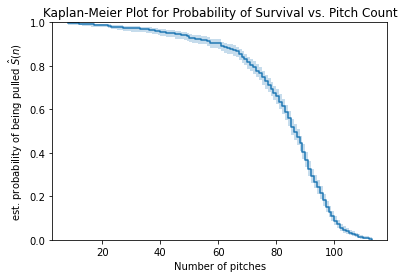

In [18]:
data_2 = dfs[dfs['last_pitch_of_game']]

time, survival_prob, conf_int = kaplan_meier_estimator(
    -data_2["is_complete_game"], data_2["pitch_count"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of being pulled $\hat{S}(n)$")
plt.xlabel("Number of pitches")
plt.title("Kaplan-Meier Plot for Probability of Survival vs. Pitch Count")

We now ask the question, "is there an association between the number of pitches thrown in plate appearances with RISP and the Hazard Rate?" We address this question using the Cox- TBD, focusing on scraping now

In [22]:
url = "https://www.insidethebook.com/li.shtml"

# 1️⃣ Download HTML
resp = requests.get(url)
resp.raise_for_status()

# 2️⃣ Parse only the tables
soup = BeautifulSoup(resp.text, "lxml")
tables = soup.find_all("table")


# 3️⃣ Pick the tableif len(tables) > 0:
target_table = tables[2]

# 4️⃣ Convert HTML table to DataFrame manually
rows = target_table.find_all("tr")
data = []
for row in rows:
    cells = [c.get_text(strip=True) for c in row.find_all(["th", "td"])]
    data.append(cells)

# Handle cases with missing headers or uneven rows
max_len = max(len(r) for r in data)
for r in data:
    while len(r) < max_len:
        r.append(None)

# 5️⃣ Make DataFrame
df_li = pd.DataFrame(data)
df_li = df_li.fillna(0)


# Optional: use first row as header if it looks like column names
if all(isinstance(x, str) for x in df_li.iloc[0]):
    df_li.columns = df_li.iloc[0]
    df_li = df_li.drop(index=0).reset_index(drop=True)

df_li.head()


,0,1,2,3,4,5,6,7,8,9,10
0,Top of Inning 1,0,0,0,0,0,0,0,0,0,0
1,,0,0,0,0,0,0,0,0,0,0
2,1 2 3,Outs,-4,-3,-2,-1,00,+1,+2,+3,+4
3,_ _ _,0,0.4,0.6,0.7,0.8,0.9,,,,
4,1 _ _,0,0.7,0.9,1.1,1.3,1.4,,,,


In [24]:
df_li = df_li.replace(r'^\s*$', np.nan, regex=True)
df_li = df_li.fillna(0)

In [ ]:
starters['base_state'] = (
    starters['on_1b'].notna().astype(int).astype(str) +
    starters['on_2b'].notna().astype(int).astype(str) +
    starters['on_3b'].notna().astype(int).astype(str)
)

In [25]:
# This cell takes all the Leverage index values and puts them into the dictionary d
d = {}
sits = ['000', '100', '010', '001', '110', '101', '011', '111']

# loop through the 18 half innings
for i in range(18):
    tb = ['Top', 'Bot'][i%2]
    
    # loop through 3 outs
    for t in range(3):
        
        # loop through eight baserunning situations
        for j in range(8):
            
            # loop through score differences
            for rd in range(-4, 5):
                
                d[tb + '_' + str(1+(i//2)) + '_' + str(t) + '_' + sits[j] + '_' + str(rd)] = float(df_li.iloc[30*i + 3 + 9*t + j][rd+6])
            

In [142]:
for rd in range(-4,5):
    print(d['Top_1_0_000_' + str(rd)])

0.4
0.6
0.7
0.8
0.9






Alright, we scraped the LI values and stored them in a dictionary! The keys encodes the following information about the plate appearance:
- Top or bottom
- Inning
- Number of outs
- Baserunners 
- Home team's lead

Now we'll use this dictionary to create a new column in our starters dataframe which captures the "Leverage Index" for the plate appearance.

In [26]:
def encode_base_state(row):
    """Return a 3-char binary string for runners on base (1B, 2B, 3B)."""
    b1 = int(row['on_1b'] > 0) if 'on_1b' in row else 0
    b2 = int(row['on_2b'] > 0) if 'on_2b' in row else 0
    b3 = int(row['on_3b'] > 0) if 'on_3b' in row else 0
    return f"{b1}{b2}{b3}"

def capped_run_diff(row):
    """Return capped run differential (home - away) within [-4, 4]."""
    diff = row['home_score'] - row['away_score']
    if diff > 4:
        return 4
    elif diff < -4:
        return -4
    else:
        return diff

# Combine all parts into one concatenated string
dfs['game_state'] = dfs.apply(
    lambda row: f"{row['inning_topbot']}" + '_'  # Top or Bot
                f"{min(int(row['inning']),9)}" + '_'         
                f"{row['outs_when_up']}" + '_'
                f"{encode_base_state(row)}" + "_"
                f"{capped_run_diff(row)}",       # + or - diff
    axis=1
)


In [188]:
dfs['LIs'] = dfs.apply(
    lambda row: d[row['game_state']],       # + or - diff
    axis=1
)


In [189]:
dfs['leverage_cumsum'] = (
    dfs.groupby(['game_pk', 'pitcher'])['LIs']
      .cumsum()
)


In [31]:
dfs.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,role,base_state,pitch_count,last_pitch_of_game,is_last_pitch,is_complete_game,game_state,LIs,leverage_cumsum
109967,3924,FF,2025-09-01,98.6,-2.10,5.34,"Dollander, Chase",671218,801403,NaN,called_strike,NaN,NaN,NaN,NaN,2.0,"Heliot Ramos grounds out, shortstop Ezequiel T...",R,R,R,COL,SF,S,NaN,NaN,0,0,2025,-0.90,0.67,0.17,2.73,NaN,NaN,NaN,0,1,Top,NaN,NaN,NaN,NaN,NaN,NaN,8.224720,-143.683098,-3.325257,-14.109707,24.014700,-22.277456,3.06,1.43,NaN,NaN,NaN,99.3,2572.0,6.0,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,230.0,0.000,-0.040,NaN,NaN,NaN,0.040,NaN,0,0,0.500,0.500,23,25,24,26,1,0,5.0,1.0,7.0,1.0,1.62,0.90,0.90,21.8,NaN,NaN,NaN,NaN,NaN,starter,000,1,False,Not Last Pitch,False,Top_1_0_000_0,0.9,0.9
109966,3746,SI,2025-09-01,96.9,-2.11,5.30,"Dollander, Chase",671218,801403,field_out,hit_into_play,NaN,NaN,NaN,NaN,1.0,"Heliot Ramos grounds out, shortstop Ezequiel T...",R,R,R,COL,SF,X,6.0,ground_ball,0,1,2025,-1.34,0.32,-0.37,3.03,NaN,NaN,NaN,0,1,Top,109.76,157.26,NaN,NaN,NaN,NaN,7.659224,-140.999181,-1.294907,-19.565270,29.315769,-27.846546,3.13,1.47,4.0,68.5,-38.0,96.5,2424.0,5.9,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.62,0.08,0.076,0.0,1.0,0.0,0.0,2.0,1,2,Sinker,0,0,0,0,0,0,0,0,Standard,Standard,236.0,0.022,-0.220,75.8,6.4,0.08,0.220,88.0,0,0,0.500,0.500,23,25,24,26,1,0,5.0,1.0,7.0,1.0,2.09,1.34,1.34,20.2,2.725533,4.178553,22.526160,32.109508,23.069677,starter,000,2,False,Not Last Pitch,False,Top_1_0_000_0,0.9,1.8
109965,3682,FF,2025-09-01,98.9,-1.97,5.39,"Dollander, Chase",646240,801403,NaN,ball,NaN,NaN,NaN,NaN,12.0,Rafael Devers homers (29) on a line drive to r...,R,L,R,COL,SF,B,NaN,NaN,0,0,2025,-1.13,1.16,0.93,4.20,NaN,NaN,NaN,1,1,Top,NaN,NaN,NaN,NaN,NaN,NaN,10.440505,-143.651725,-0.525088,-17.971889,32.344342,-16.204343,3.57,1.72,NaN,NaN,NaN,98.2,2443.0,5.9,776492,696100,606115,671289,691720,678662,687597,686668,666160,54.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Infield shade,Standard,233.0,0.000,0.039,NaN,NaN,NaN,-0.039,NaN,0,0,0.522,0.478,23,28,24,29,1,0,5.0,1.0,7.0,1.0,1.18,1.13,-1.13,20.3,NaN,NaN,NaN,NaN,NaN,starter,000,3,False,Not Last Pitch,False,Top_1_1_000_0,0.6,2.4
109964,3558,FF,2025-09-01,99.5,-2.20,5.32,"Dollander, Chase",646240,801403,NaN,called_strike,NaN,NaN,NaN,NaN,1.0,Rafael Devers homers (29) on a 

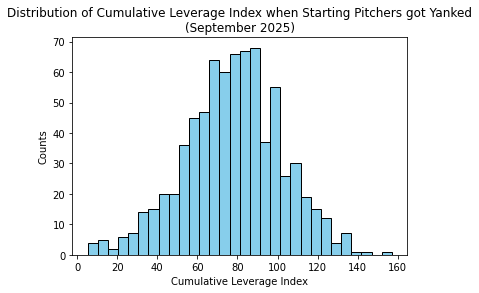

In [190]:
# Generate random data for the histogram
last_pitch_cumLI = dfs[dfs['last_pitch_of_game']][['leverage_cumsum', 'pitcher', 'pitch_count']]
# Plotting a basic histogram
plt.hist(last_pitch_cumLI['leverage_cumsum'], bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Cumulative Leverage Index')
plt.ylabel('Counts')
plt.title('Distribution of Cumulative Leverage Index when Starting Pitchers got Yanked\n(September 2025)')

# Display the plot
plt.show()

In [191]:
last_pitch_cumLI.head(10)

,leverage_cumsum,pitcher,pitch_count
109820,65.7,801403,84
109776,101.1,678906,85
109504,111.2,656302,91
109490,99.4,680694,84
109165,99.3,669194,97
109147,71.1,571578,92
108847,98.3,806960,91
108830,72.2,543243,82
108673,26.6,669199,39
108597,90.4,674841,81


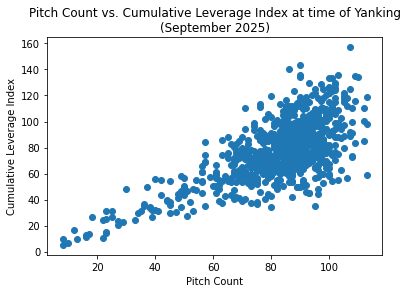

In [35]:
x = last_pitch_cumLI['pitch_count']
y = last_pitch_cumLI['leverage_cumsum']

plt.scatter(x, y)
plt.title("Pitch Count vs. Cumulative Leverage Index at time of Yanking\n(September 2025)")
plt.xlabel("Pitch Count")
plt.ylabel("Cumulative Leverage Index")
plt.show()


In [45]:
last_pitch_cumLI.head()

,leverage_cumsum,pitcher,pitch_count
109820,65.7,801403,84
109776,101.1,678906,85
109504,111.2,656302,91
109490,99.4,680694,84
109165,99.3,669194,97


In [192]:
last_pitch_cumLI['binary'] = np.full(len(last_pitch_cumLI), True)

In [193]:
data_x = pd.DataFrame(last_pitch_cumLI['leverage_cumsum'])
data_y = Surv.from_arrays(
    event=last_pitch_cumLI["binary"].astype(bool),
    time=last_pitch_cumLI["pitch_count"]
)

In [194]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,leverage_cumsum
109820,65.7
109776,101.1
109504,111.2
109490,99.4
109165,99.3


In [195]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [196]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

leverage_cumsum   -0.027954
dtype: float64

In [197]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

model = CoxPHSurvivalAnalysis().fit(data_x, data_y)
base_coef = model.coef_

In [198]:
def bootstrap_cox(model_class, X, y, n_bootstrap=1000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(X)
    coefs = np.zeros((n_bootstrap, X.shape[1]))

    for i in range(n_bootstrap):
        # resample indices with replacement
        idx = rng.choice(n, n, replace=True)
        Xb = X.iloc[idx]
        yb = y[idx]
        
        # fit model and store coefficients
        try:
            model = model_class().fit(Xb, yb)
            coefs[i, :] = model.coef_
        except Exception:
            coefs[i, :] = np.nan  # handle failed fits gracefully
    
    return coefs


In [199]:
boot_coefs = bootstrap_cox(CoxPHSurvivalAnalysis, data_x, data_y, n_bootstrap=500, random_state=42)

In [200]:
# Compute summary stats
boot_df = pd.DataFrame(boot_coefs, columns=data_x.columns)
boot_df = boot_df.dropna()  # drop failed fits

# mean & std (bootstrap-based SE)
boot_mean = boot_df.mean()
boot_se = boot_df.std()

# 95% confidence intervals (percentile method)
ci_lower = boot_df.quantile(0.025)
ci_upper = boot_df.quantile(0.975)

# Combine into a summary DataFrame
summary = pd.DataFrame({
    "coef": base_coef,
    "exp(coef)": np.exp(base_coef),
    "boot_SE": boot_se,
    "95% CI lower": ci_lower,
    "95% CI upper": ci_upper,
    "exp(95% CI lower)": np.exp(ci_lower),
    "exp(95% CI upper)": np.exp(ci_upper)
})


In [201]:
from scipy.stats import norm

z = base_coef / boot_se
p_values = 2 * (1 - norm.cdf(np.abs(z)))

summary["z"] = z
summary["p"] = p_values


In [202]:
summary.head()

,coef,exp(coef),boot_SE,95% CI lower,95% CI upper,exp(95% CI lower),exp(95% CI upper),z,p
leverage_cumsum,-0.027954,0.972433,0.002358,-0.032718,-0.023804,0.967811,0.976478,-11.854097,0.0


So from the summary above, we reject the null hypothesis above and conclude that there's an association between the cumulative leverage index and the probability of a starting pitcher being replaced. 

Now let's compare the previous model to 

In [203]:
def runs_on_pitch(row):
    """Return a 3-char binary string for runners on base (1B, 2B, 3B)."""
    return row['post_home_score'] + row['post_away_score'] - row['home_score'] - row['away_score']

In [204]:
# Combine all parts into one concatenated string
dfs['runs_on_pitch'] = dfs.apply(
    lambda row: runs_on_pitch(row),
    axis=1
)


In [205]:
dfs['runs_cumsum'] = (
    dfs.groupby(['game_pk', 'pitcher'])['runs_on_pitch']
      .cumsum()
)


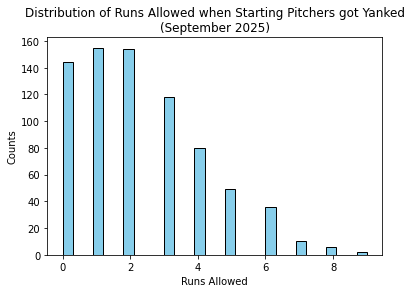

In [294]:
# Generate random data for the histogram
# Plotting a basic histogram
plt.hist(last_pitch_cumLI['runs_cumsum'], bins=30, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Runs Allowed')
plt.ylabel('Counts')
plt.title('Distribution of Runs Allowed when Starting Pitchers got Yanked\n(September 2025)')

# Display the plot
plt.show()

In [207]:
run_counts = last_pitch_cumLI['runs_cumsum'].value_counts()

In [208]:
run_counts.sort_index(inplace = True)
run_counts

0    144
1    155
2    154
3    118
4     80
5     49
6     36
7     10
8      6
9      2
Name: runs_cumsum, dtype: int64

In [209]:
run_counts.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

<AxesSubplot:xlabel='Runs', ylabel='Number of Outings'>

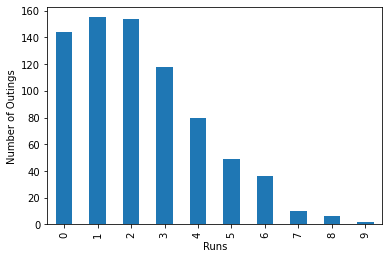

In [210]:
run_counts.plot.bar(xlabel = 'Runs', ylabel='Number of Outings')

In [213]:
last_pitch_cumLI['binary'] = np.full(len(last_pitch_cumLI), True)

In [214]:
data_x = pd.DataFrame(last_pitch_cumLI['runs_cumsum'])
data_y = Surv.from_arrays(
    event=last_pitch_cumLI["binary"].astype(bool),
    time=last_pitch_cumLI["pitch_count"]
)

In [215]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,runs_cumsum
109820,6
109776,0
109504,2
109490,2
109165,3


In [223]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [229]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

runs_cumsum    0.05221
dtype: float64

In [230]:
model = CoxPHSurvivalAnalysis().fit(data_x, data_y)
base_coef = model.coef_

In [231]:
boot_coefs = bootstrap_cox(CoxPHSurvivalAnalysis, data_x, data_y, n_bootstrap=500, random_state=42)

In [232]:
# Compute summary stats
boot_df = pd.DataFrame(boot_coefs, columns=data_x.columns)
boot_df = boot_df.dropna()  # drop failed fits

# mean & std (bootstrap-based SE)
boot_mean = boot_df.mean()
boot_se = boot_df.std()

# 95% confidence intervals (percentile method)
ci_lower = boot_df.quantile(0.025)
ci_upper = boot_df.quantile(0.975)

# Combine into a summary DataFrame
summary = pd.DataFrame({
    "coef": base_coef,
    "exp(coef)": np.exp(base_coef),
    "boot_SE": boot_se,
    "95% CI lower": ci_lower,
    "95% CI upper": ci_upper,
    "exp(95% CI lower)": np.exp(ci_lower),
    "exp(95% CI upper)": np.exp(ci_upper)
})


In [233]:
from scipy.stats import norm

z = base_coef / boot_se
p_values = 2 * (1 - norm.cdf(np.abs(z)))

summary["z"] = z
summary["p"] = p_values


In [235]:
summary.head()

,coef,exp(coef),boot_SE,95% CI lower,95% CI upper,exp(95% CI lower),exp(95% CI upper),z,p
runs_cumsum,0.05221,1.053597,0.021032,0.012906,0.093043,1.012989,1.097508,2.482449,0.013048


In [262]:
X_plot = data_x.copy()
bins = [0, 3, 5, 100]  # adjust for your variable’s range
labels = ["Low", "Medium", "High"]
X_plot["myvar_group"] = pd.cut(X_plot["runs_cumsum"], bins=bins, labels=labels, include_lowest=True)


In [263]:
group_profiles = (
    X_plot.groupby("myvar_group")["runs_cumsum"]
    .mean()
    .reset_index()
)

# Copy base covariates (set to their mean)
X_mean = data_x.mean().to_frame().T

# Build new data matrix with the mean covariates, except `myvar` varies by group
X_pred = pd.concat([
    X_mean.assign(runs_cumsum=row["runs_cumsum"]) for _, row in group_profiles.iterrows()
], ignore_index=True)

X_pred["myvar_group"] = group_profiles["runs_cumsum"].values


In [264]:
# Compute the mean value of `myvar` within each group
group_means = X_plot.groupby("myvar_group")["runs_cumsum"].mean()

In [265]:
# Create a baseline feature vector using mean values of all features
X_mean = data_x.mean().to_frame().T

# Make 3 rows — identical except for myvar value
X_pred = pd.concat(
    [X_mean.assign(runs_cumsum=val) for val in group_means],
    ignore_index=True
)

# Add group labels separately (for plotting only)
X_pred_labels = group_means.index.to_list()


In [266]:
surv_funcs = model.predict_survival_function(X_pred)


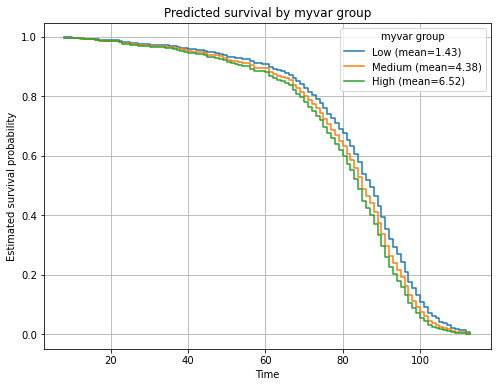

In [267]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for fn, label, val in zip(surv_funcs, X_pred_labels, group_means):
    plt.step(fn.x, fn(fn.x), where="post", label=f"{label} (mean={val:.2f})")

plt.xlabel("Time")
plt.ylabel("Estimated survival probability")
plt.title("Predicted survival by myvar group")
plt.legend(title="myvar group")
plt.grid(True)
plt.show()


In [268]:
import pandas as pd

X_mean = data_x.mean().to_frame().T  # baseline profile
levels = range(10)  # 0–9

# Build prediction rows, one per level
X_pred = pd.concat(
    [X_mean.assign(runs_cumsum=level) for level in levels],
    ignore_index=True
)


In [260]:
surv_funcs = model.predict_survival_function(X_pred)


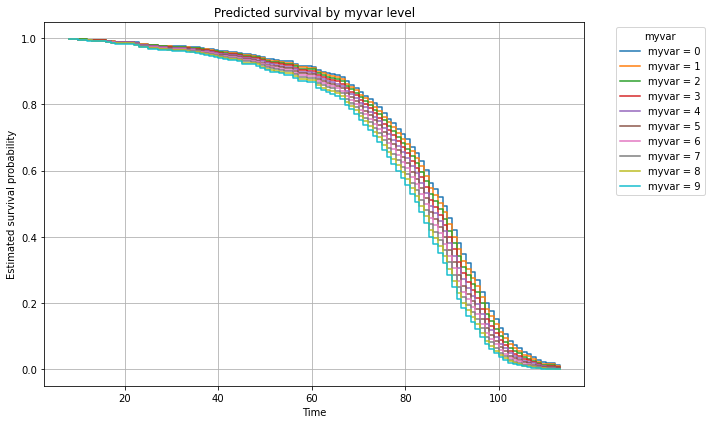

In [261]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for fn, level in zip(surv_funcs, levels):
    plt.step(fn.x, fn(fn.x), where="post", label=f"myvar = {level}")

plt.xlabel("Time")
plt.ylabel("Estimated survival probability")
plt.title("Predicted survival by myvar level")
plt.legend(title="myvar", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


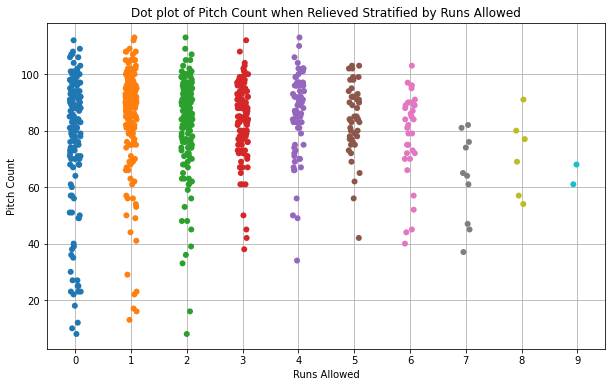

In [299]:
    # Example: raw data DataFrame
# df = pd.DataFrame({"myvar": ..., "response": ...})

plt.figure(figsize=(10,6))
sns.stripplot(x="runs_cumsum", y="pitch_count", data=last_pitch_cumLI, size=6, jitter=True, palette="tab10")
# sns.pointplot(x="runs_cumsum", y="pitch_count", data=last_pitch_cumLI, estimator='mean', color='red', markers='D', ci=None)

plt.xlabel("Runs Allowed")
plt.ylabel("Pitch Count")
plt.title("Dot plot of Pitch Count when Relieved Stratified by Runs Allowed")
plt.grid(True)
plt.show()


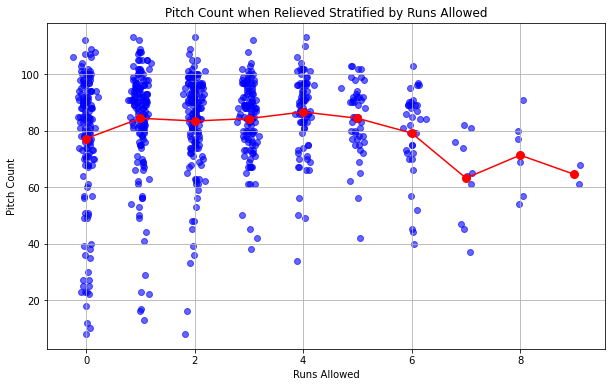

In [302]:
plt.figure(figsize=(10,6))

levels = sorted(last_pitch_cumLI["runs_cumsum"].unique())

# Plot individual dots with jitter
for level in levels:
    y = last_pitch_cumLI.loc[last_pitch_cumLI["runs_cumsum"] == level, "pitch_count"]
    x = np.random.normal(level, 0.08, size=len(y))  # jitter
    plt.scatter(x, y, alpha=0.6, color='blue')

# Compute and plot means
means = last_pitch_cumLI.groupby("runs_cumsum")["pitch_count"].mean()
plt.plot(levels, means, color='red', marker='o', linestyle='-', markersize=8)

plt.xlabel("Runs Allowed")
plt.ylabel("Pitch Count")
plt.title("Pitch Count when Relieved Stratified by Runs Allowed")
plt.grid(True)
plt.show()


In [269]:
def RISP_pitch(row):
    if '1' in row['base_state'][1:]:
        return 1
    return 0

In [270]:
# Combine all parts into one concatenated string
dfs['RISP_pitch'] = dfs.apply(
    lambda row: RISP_pitch(row),
    axis=1
)


In [271]:
dfs['RISP_cumsum'] = (
    dfs.groupby(['game_pk', 'pitcher'])['RISP_pitch']
      .cumsum()
)


In [277]:
last_pitch_cumLI = dfs[dfs['last_pitch_of_game']][['RISP_cumsum', 'pitcher', 'pitch_count']]

In [278]:
last_pitch_cumLI['binary'] = np.full(len(last_pitch_cumLI), True)

In [279]:
data_x = pd.DataFrame(last_pitch_cumLI['RISP_cumsum'])
data_y = Surv.from_arrays(
    event=last_pitch_cumLI["binary"].astype(bool),
    time=last_pitch_cumLI["pitch_count"]
)

In [280]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,RISP_cumsum
109820,17
109776,31
109504,53
109490,24
109165,10


In [281]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [288]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

RISP_cumsum   -0.012929
dtype: float64

In [289]:
model = CoxPHSurvivalAnalysis().fit(data_x, data_y)
base_coef = model.coef_

In [290]:
boot_coefs = bootstrap_cox(CoxPHSurvivalAnalysis, data_x, data_y, n_bootstrap=500, random_state=42)

In [291]:
# Compute summary stats
boot_df = pd.DataFrame(boot_coefs, columns=data_x.columns)
boot_df = boot_df.dropna()  # drop failed fits

# mean & std (bootstrap-based SE)
boot_mean = boot_df.mean()
boot_se = boot_df.std()

# 95% confidence intervals (percentile method)
ci_lower = boot_df.quantile(0.025)
ci_upper = boot_df.quantile(0.975)

# Combine into a summary DataFrame
summary = pd.DataFrame({
    "coef": base_coef,
    "exp(coef)": np.exp(base_coef),
    "boot_SE": boot_se,
    "95% CI lower": ci_lower,
    "95% CI upper": ci_upper,
    "exp(95% CI lower)": np.exp(ci_lower),
    "exp(95% CI upper)": np.exp(ci_upper)
})

In [292]:
from scipy.stats import norm

z = base_coef / boot_se
p_values = 2 * (1 - norm.cdf(np.abs(z)))

summary["z"] = z
summary["p"] = p_values


In [293]:
summary.head()

,coef,exp(coef),boot_SE,95% CI lower,95% CI upper,exp(95% CI lower),exp(95% CI upper),z,p
RISP_cumsum,-0.012929,0.987154,0.003332,-0.019591,-0.006127,0.980599,0.993891,-3.880326,0.000104
